In [1]:
import sys
import os
import seaborn as sns
from dotenv import load_dotenv
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Update the connection details with your own values
host = 'localhost'
port = '5432'
database = 'postgres'
user = 'postgres'
password = 'pass123'



In [3]:
def connect():
    conn = None
    try:
        print('Connecting..')
        conn = psycopg2.connect(
              host=host,
              database=database,
              user=user,
              password=password
        )
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        sys.exit(1)   
        
    print("All good, Connection successful!")
    return conn

In [4]:
def sql_to_dataframe(conn, query):
    """Import data from a PostgreSQL database using a SELECT query"""
    cursor = conn.cursor()   
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    # The execute returns a list of tuples:   
    tuples_list = cursor.fetchall()   
    
    # Now we need to transform the list into a pandas DataFrame:   
    df = pd.DataFrame(tuples_list, columns=[col[0] for col in cursor.description])
    cursor.close()   
    return df

In [5]:
# create query
query = """ SELECT * FROM public.xdr_data  """

#opening the connection
conn = connect()

#loading our dataframe
df = sql_to_dataframe(conn, query)

#closing the connection
conn.close()

Connecting..
All good, Connection successful!


In [6]:
# Let’s see if we loaded the df successfully
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [7]:
# Aggregate the engagement metrics per customer id (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Start': 'count',  # sessions frequency
    'Dur. (ms).1': 'sum',  # session duration
    'Total UL (Bytes)': 'sum',  # total upload traffic
    'Total DL (Bytes)': 'sum'  # total download traffic
})
engagement_metrics.columns = ['Sessions Frequency', 'Session Duration', 'Total Upload Traffic', 'Total Download Traffic']

In [20]:
# Report the top 10 customers per engagement metric
top_10_sessions_freq = engagement_metrics.sort_values('Sessions Frequency', ascending=False).head(10)
top_10_session_dur = engagement_metrics.sort_values('Session Duration', ascending=False).head(10)
top_10_total_upload = engagement_metrics.sort_values('Total Upload Traffic', ascending=False).head(10)
top_10_total_download = engagement_metrics.sort_values('Total Download Traffic', ascending=False).head(10)


In [17]:
# Display the top 10 customers per engagement metric
print("Top 10 Customers per Sessions Frequency:")
print(top_10_sessions_freq)
print("\nTop 10 Customers per Session Duration:")
print(top_10_session_dur)
print("\nTop 10 Customers per Session Upload Traffic:")
print(top_10_total_upload)
print("\nTop 10 Customers per Session Download Traffic:")
print(top_10_total_download)

Top 10 Customers per Sessions Frequency:
               Sessions Frequency  Session Duration  Total Upload Traffic  \
MSISDN/Number                                                               
3.362632e+10                   18      8.791937e+09           669650721.0   
3.362578e+10                   17      1.855376e+10           729577380.0   
3.361489e+10                   17      9.966906e+09           689483001.0   
3.365973e+10                   16      4.035436e+09           624260321.0   
3.376054e+10                   15      9.279442e+09           703478581.0   
3.367588e+10                   15      4.865954e+09           581568792.0   
3.366716e+10                   13      8.744922e+09           566326364.0   
3.362708e+10                   12      4.703519e+09           445251947.0   
3.360452e+10                   12      5.207995e+09           391775856.0   
3.376041e+10                   12      5.321674e+09           521518890.0   

               Total Download Traf

In [9]:
# Normalize each engagement metric
normalized_engagement_metrics = (engagement_metrics - engagement_metrics.min()) / (engagement_metrics.max() - engagement_metrics.min())

In [10]:
# Run k-means clustering (k=3) on normalized engagement metrics

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(normalized_engagement_metrics)


c:\Users\huawei\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [11]:
# Add cluster labels to the engagement metrics dataframe
engagement_metrics['Cluster'] = clusters

In [12]:
# Compute the minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration': ['min', 'max', 'mean', 'sum'],
    'Total Upload Traffic': ['min', 'max', 'mean', 'sum'],
    'Total Download Traffic': ['min', 'max', 'mean', 'sum']
})

In [13]:
# Aggregate user total traffic per application
application_traffic = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum'
})

In [14]:
# Derive the top 10 most engaged users per application
top_10_social_media = application_traffic.sort_values('Social Media DL (Bytes)', ascending=False).head(10)
top_10_google = application_traffic.sort_values('Google DL (Bytes)', ascending=False).head(10)
top_10_email = application_traffic.sort_values('Email DL (Bytes)', ascending=False).head(10)


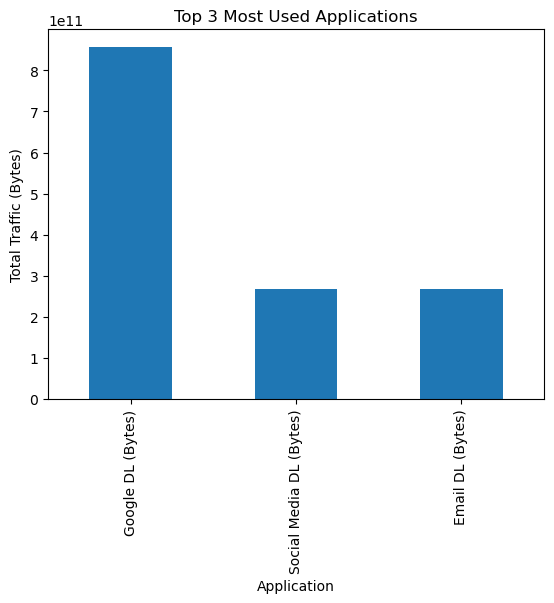

In [15]:
# Plot the top 3 most used applications
top_3_applications = application_traffic[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)']].sum().nlargest(3)
top_3_applications.plot(kind='bar', xlabel='Application', ylabel='Total Traffic (Bytes)', title='Top 3 Most Used Applications')

plt.show()